#Proyek Klasifikasi Gambar: rice-image-dataset

*   Nama: Siga Petra Rastoni
*   Email: sigapetra02@gmail.com





In [1]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
shutil.copy('/tmp/tmpa_s5if2x', '/content/drive/MyDrive/Colab Notebooks/IDCamp24') # Replace 'my_artifact' with your desired file name

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpa_s5if2x'

In [7]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


#Data Preparation

In [10]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
rice-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  rice-image-dataset.zip
replace Rice_Image_Dataset/Arborio/Arborio (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
import shutil
import random
from sklearn.model_selection import train_test_split

# Define dataset_root with the path to the main dataset
# The dataset was extracted to 'rice-image-dataset' directory
dataset_root = 'Rice_Image_Dataset'  # Changed to the correct folder name

# Path to the main dataset
dataset_path = dataset_root  # Use the root directory directly

# Get the list of classes
classes = os.listdir(dataset_path)

# Create folders for train, validation, and test
train_dir = "rice_dataset/train"
val_dir = "rice_dataset/val"
test_dir = "rice_dataset/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class in the dataset
for class_name in classes: # Iterate through the list of classes
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        # Split the data into temporary train and test sets
        train_temp_dir, test_dir_temp = train_test_split(os.listdir(class_dir), test_size=0.2, random_state=42)

        # Further split the temporary train data into train and validation sets
        train_files, val_files = train_test_split(train_temp_dir, test_size=0.2, random_state=42)

        # Create class folders within the train, validation, and test folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move files to the appropriate folders
        for file_name in train_files:
            shutil.copy(os.path.join(class_dir, file_name), os.path.join(train_dir, class_name, file_name))
        for file_name in val_files:
            shutil.copy(os.path.join(class_dir, file_name), os.path.join(val_dir, class_name, file_name))
        for file_name in test_dir_temp:
            shutil.copy(os.path.join(class_dir, file_name), os.path.join(test_dir, class_name, file_name))

#Datasets Checking

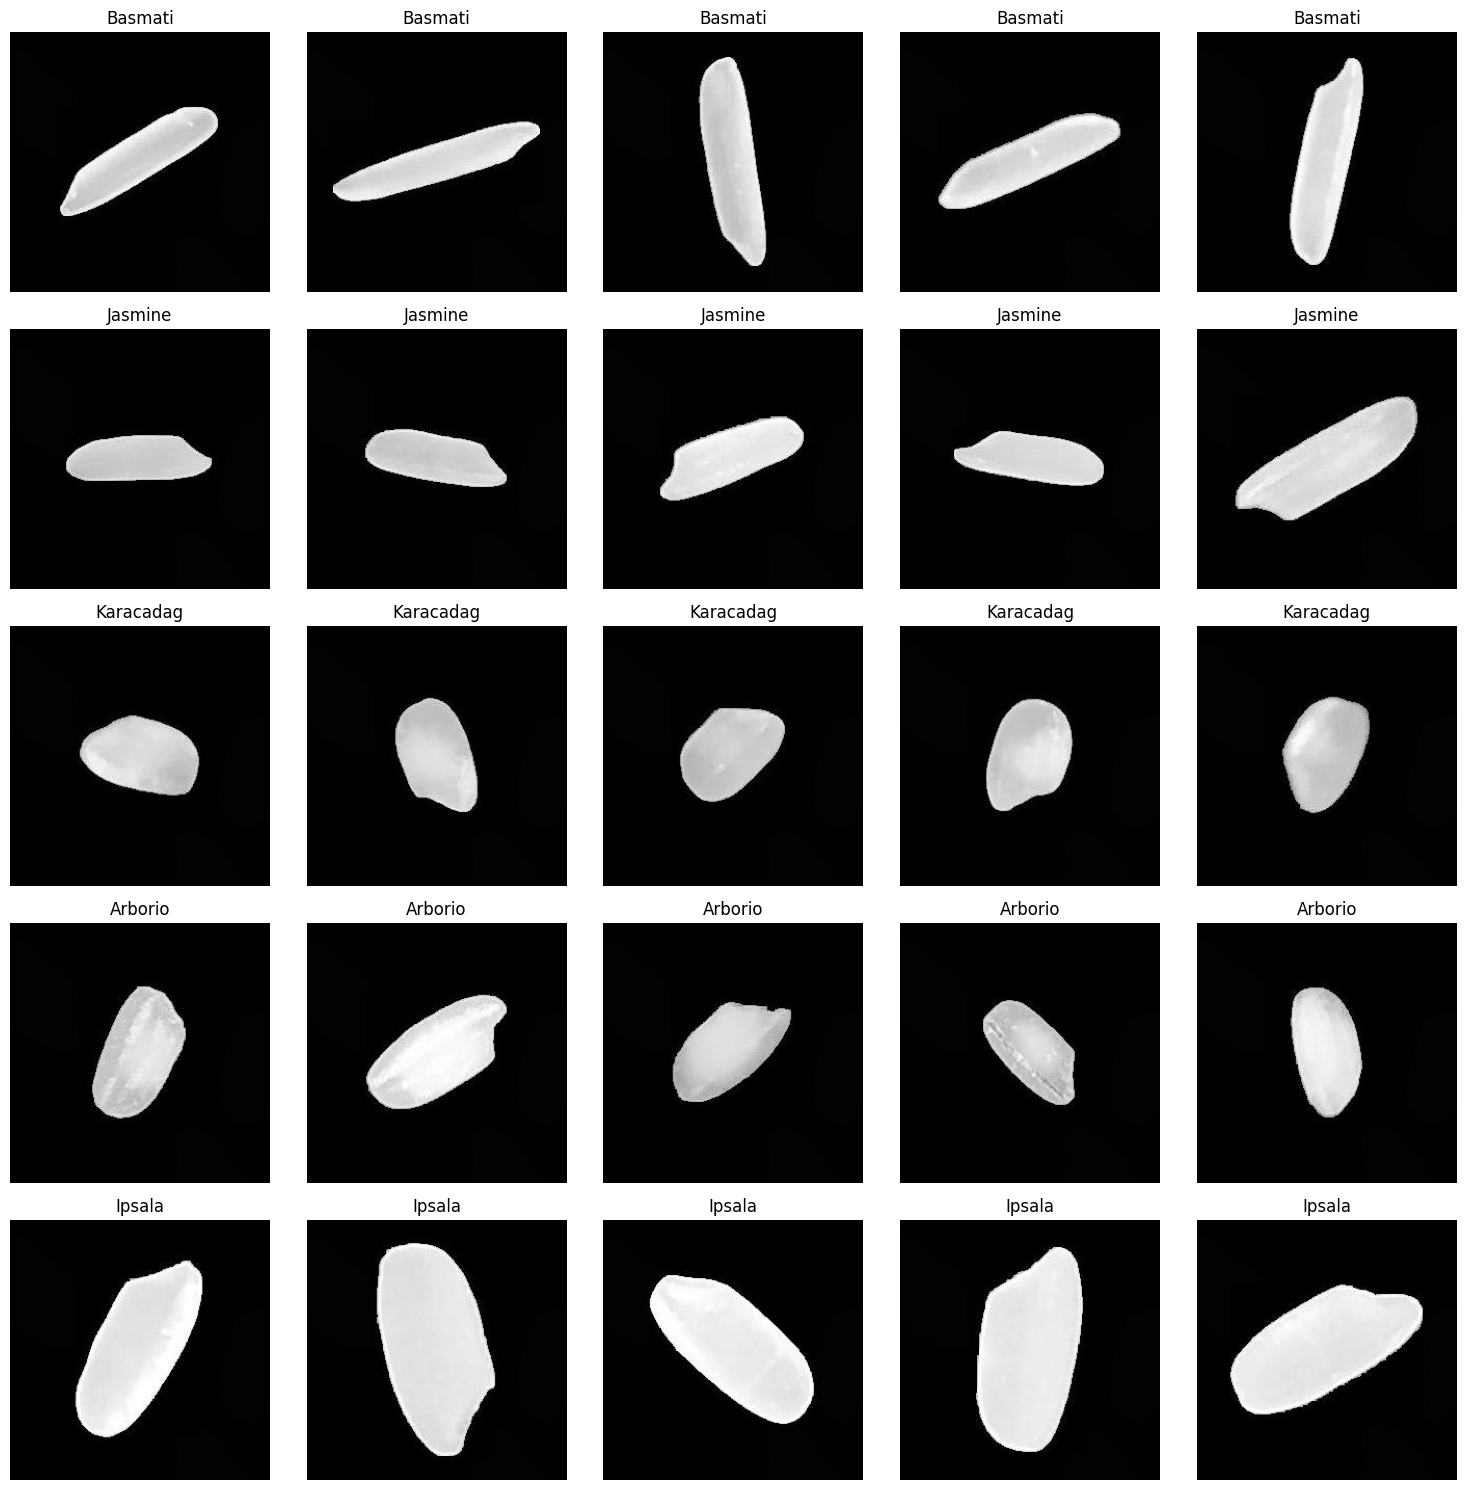

In [12]:
import matplotlib.pyplot as plt
from PIL import Image


# Path dataset setelah diproses
# Change dataset_path to the correct location where the data was extracted
dataset_path = dataset_root

# Membuat kamus yang menyimpan daftar gambar untuk setiap kelas
rice_images = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya folder kelas yang diproses
        rice_images[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar secara acak dari setiap kelas
num_images = 5
fig, axs = plt.subplots(len(rice_images), num_images, figsize=(15, len(rice_images) * 3))

for i, (class_name, images) in enumerate(rice_images.items()):
    # Pastikan ada cukup gambar dalam kelas sebelum memilih
    if len(images) < num_images:
        print(f"Warning: Kelas '{class_name}' hanya memiliki {len(images)} gambar. Menggunakan semua gambar yang tersedia.")
        selected_images = images  # Gunakan semua gambar yang ada
    else:
        selected_images = np.random.choice(images, num_images, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi grayscale

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(class_name)  # Tambahkan judul per kelas
        axs[i, j].axis("off")  # Hilangkan axis untuk tampilan lebih rapi

fig.tight_layout()
plt.show()

#Plot Distribusi

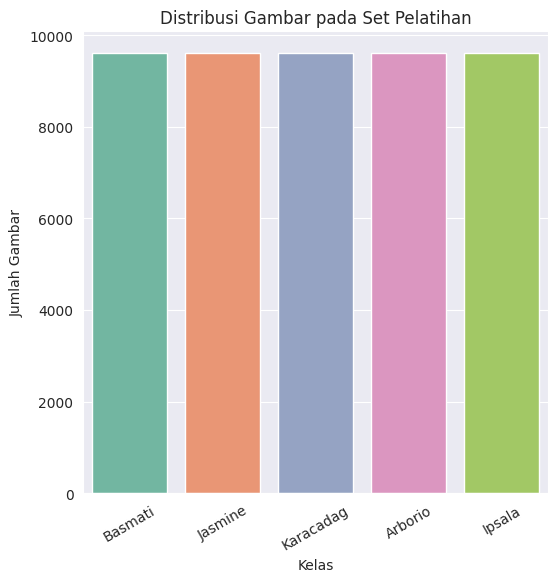

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definisikan path sumber dataset
rice_path = "rice_dataset/train/"

# Buat list untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Looping untuk mendapatkan path gambar dan label
for path, subdirs, files in os.walk(rice_path):
    for name in files:
        if name.endswith(('.png', '.jpg', '.jpeg')):  # Pastikan hanya file gambar
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # Ambil nama folder sebagai label
            file_name.append(name)

# Simpan data ke dalam DataFrame
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_train, x="labels", palette="Set2")

plt.title("Distribusi Gambar pada Set Pelatihan")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=30)
plt.show()


#Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation untuk data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya rescale untuk data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.


#Data Splitting

In [15]:
# Definisikan path sumber dataset
rice_path = "rice_dataset/train/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(rice_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()



,0
labels,
Arborio,9600
Basmati,9600
Ipsala,9600
Jasmine,9600
Karacadag,9600


In [16]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [17]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [18]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Rice_Image_Dataset"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   Arborio      1893
       Basmati      1963
       Ipsala       1935
       Jasmine      1883
       Karacadag    1926
train  Arborio      7707
       Basmati      7637
       Ipsala       7665
       Jasmine      7717
       Karacadag    7674
dtype: int64 


                                                path   labels    set
11484  rice_dataset/train/Arborio/Arborio (4883).jpg  Arborio  train
19226  rice_dataset/train/Jasmine/Jasmine (4678).jpg  Jasmine  train
42455  rice_dataset/train/Arborio/Arborio (9736).jpg  Arborio   test
13781  rice_dataset/train/Jasmine/Jasmine (2902).jpg  Jasmine  train
46053   rice_dataset/train/Arborio/Arborio (431).jpg  Arborio   test


In [19]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#Image Data Generator

In [20]:
# Define paths using os.path.join
train_dir = "Dataset-Final/train/"
test_dir = "Dataset-Final/test/"

# List of rice varieties
rice_varieties = ['Arborio', 'Basmati', 'Karacadag', 'Ipsala', 'Jasmine']

# Create dictionaries to store paths
train_paths = {variety: os.path.join(train_dir, variety) for variety in rice_varieties}
test_paths = {variety: os.path.join(test_dir, variety) for variety in rice_varieties}

for variety in ['Arborio', 'Basmati', 'Karacadag', 'Ipsala', 'Jasmine']:
    print(f"Total number of {variety} images in training set: ", len(os.listdir(train_paths[variety])))
    print(f"Total number of {variety} images in test set: ", len(os.listdir(test_paths[variety])))

# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(train_dir,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Total number of Arborio images in training set:  7707
Total number of Arborio images in test set:  1893
Total number of Basmati images in training set:  7637
Total number of Basmati images in test set:  1963
Total number of Karacadag images in training set:  7674
Total number of Karacadag images in test set:  1926
Total number of Ipsala images in training set:  7665
Total number of Ipsala images in test set:  1935
Total number of Jasmine images in training set:  7717
Total number of Jasmine images in test set:  1883
Found 30722 images belonging to 5 classes.
Found 7678 images belonging to 5 classes.
Found 9600 images belonging to 5 classes.


#Skema CNN Architecture dengan 32 Neurons pada Conv Layer

In [21]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu')) # Changed activation to 'relu'
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu')) # Changed activation to 'relu'
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 5 classes in dataset, softmax for multi-class cases
model_1.add(Dense(5, activation='softmax')) # Changed to 5 units and 'softmax' activation
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy', # Changed loss to 'categorical_crossentropy'
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,403,141 (5.35 MB)

 Trainable params: 1,402,949 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [22]:
# Get the counts for all rice varieties
count_arborio = len(os.listdir(train_paths['Arborio']))
count_basmati = len(os.listdir(train_paths['Basmati']))
count_karacadag = len(os.listdir(train_paths['Karacadag']))
count_ipsala = len(os.listdir(train_paths['Ipsala']))
count_jasmine = len(os.listdir(train_paths['Jasmine']))

# Calculate total number of samples
total_samples = count_arborio + count_basmati + count_karacadag + count_ipsala + count_jasmine

# Calculate class weights for all varieties
weight_0 = (1 / count_arborio) * (total_samples) / 5.0  # Arborio
weight_1 = (1 / count_basmati) * (total_samples) / 5.0  # Basmati
weight_2 = (1 / count_karacadag) * (total_samples) / 5.0  # Karacadag
weight_3 = (1 / count_ipsala) * (total_samples) / 5.0  # Ipsala
weight_4 = (1 / count_jasmine) * (total_samples) / 5.0  # Jasmine

class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3, 4: weight_4}

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Latih model dengan callbacks dan class weights
history_1 = model_1.fit(
            train_generator,
            epochs=30,
            batch_size=32,
            validation_data=validation_generator,
            callbacks=callbacks,
            class_weight=class_weights
)



Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6776 - loss: 1.0682

961/961 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - accuracy: 0.6778 - loss: 1.0678 - val_accuracy: 0.9449 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 2/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8852 - loss: 0.3197

961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.8852 - loss: 0.3197 - val_accuracy: 0.9680 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 3/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9013 - loss: 0.2811 - val_accuracy: 0.9303 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 4/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9025 - loss: 0.2710 - val_accuracy: 0.8759 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 5/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9113 - loss: 0.2519 - val_accuracy: 0.8042 - val_loss: 0.3648 - learning_rate: 0.0010
Epoch 6/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9158 - loss: 0.2113

961/961 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9158 - loss: 0.2113 - val_accuracy: 0.9681 - val_loss: 0.0795 - learning_rate: 2.0000e-04
Epoch 7/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9266 - loss: 0.1647 - val_accuracy: 0.9656 - val_loss: 0.1157 - learning_rate: 2.0000e-04
Epoch 8/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9388 - loss: 0.1566

961/961 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9388 - loss: 0.1566 - val_accuracy: 0.9818 - val_loss: 0.0721 - learning_rate: 2.0000e-04
Epoch 9/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9564 - loss: 0.1434 - val_accuracy: 0.9755 - val_loss: 0.0943 - learning_rate: 2.0000e-04
Epoch 10/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9660 - loss: 0.1301 - val_accuracy: 0.9737 - val_loss: 0.1484 - learning_rate: 2.0000e-04
Epoch 11/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9666 - loss: 0.1214 - val_accuracy: 0.8440 - val_loss: 4.6382 - learning_rate: 2.0000e-04
Epoch 12/30
960/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9709 - loss: 0.1193

961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9709 - loss: 0.1193 - val_accuracy: 0.9885 - val_loss: 0.0428 - learning_rate: 4.0000e-05
Epoch 13/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9751 - loss: 0.0985

961/961 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9751 - loss: 0.0985 - val_accuracy: 0.9898 - val_loss: 0.0378 - learning_rate: 4.0000e-05
Epoch 14/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9771 - loss: 0.0942 - val_accuracy: 0.9874 - val_loss: 0.0496 - learning_rate: 4.0000e-05
Epoch 15/30
960/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9765 - loss: 0.0935

961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9765 - loss: 0.0935 - val_accuracy: 0.9909 - val_loss: 0.0367 - learning_rate: 4.0000e-05
Epoch 16/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9777 - loss: 0.0898 - val_accuracy: 0.9888 - val_loss: 0.0431 - learning_rate: 4.0000e-05
Epoch 17/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9809 - loss: 0.0779 - val_accuracy: 0.9904 - val_loss: 0.0366 - learning_rate: 4.0000e-05
Epoch 18/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9791 - loss: 0.0906 - val_accuracy: 0.9902 - val_loss: 0.0371 - learning_rate: 4.0000e-05
Epoch 19/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9804 - loss: 0.0772

961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9804 - loss: 0.0772 - val_accuracy: 0.9910 - val_loss: 0.0341 - learning_rate: 4.0000e-05
Epoch 20/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9815 - loss: 0.0727

961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9815 - loss: 0.0727 - val_accuracy: 0.9914 - val_loss: 0.0348 - learning_rate: 4.0000e-05
Epoch 21/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9812 - loss: 0.0797 - val_accuracy: 0.9898 - val_loss: 0.0453 - learning_rate: 4.0000e-05
Epoch 22/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9822 - loss: 0.0769 - val_accuracy: 0.9867 - val_loss: 0.0488 - learning_rate: 4.0000e-05
Epoch 23/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9817 - loss: 0.0771

961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9817 - loss: 0.0771 - val_accuracy: 0.9918 - val_loss: 0.0328 - learning_rate: 8.0000e-06
Epoch 24/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9824 - loss: 0.0733

961/961 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9824 - loss: 0.0733 - val_accuracy: 0.9919 - val_loss: 0.0324 - learning_rate: 8.0000e-06
Epoch 25/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9819 - loss: 0.0737

961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9819 - loss: 0.0737 - val_accuracy: 0.9921 - val_loss: 0.0322 - learning_rate: 8.0000e-06
Epoch 26/30
960/961 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9837 - loss: 0.0699

961/961 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9837 - loss: 0.0699 - val_accuracy: 0.9924 - val_loss: 0.0324 - learning_rate: 8.0000e-06
Epoch 27/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9832 - loss: 0.0761 - val_accuracy: 0.9919 - val_loss: 0.0312 - learning_rate: 8.0000e-06
Epoch 28/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9825 - loss: 0.0697 - val_accuracy: 0.9919 - val_loss: 0.0325 - learning_rate: 8.0000e-06
Epoch 29/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9822 - loss: 0.0707 - val_accuracy: 0.9921 - val_loss: 0.0328 - learning_rate: 8.0000e-06
Epoch 30/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.9852 - loss: 0.0668 - val_accuracy: 0.9919 - val_loss: 0.0321 - learning_rate: 8.0000e-06


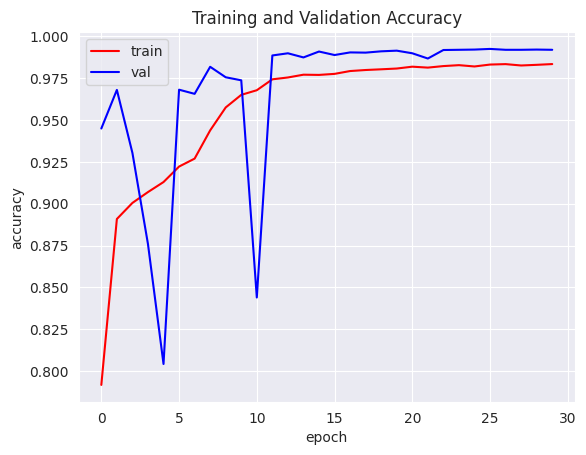

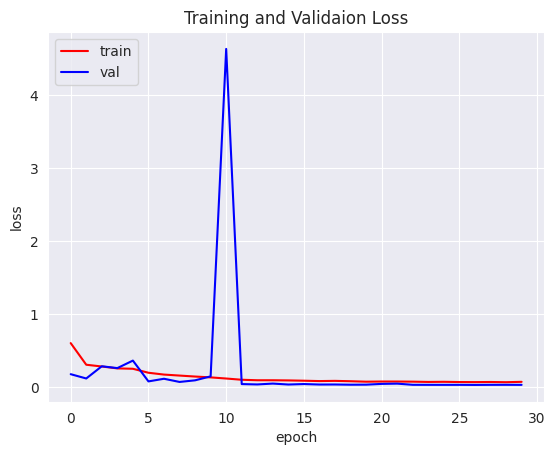

In [23]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

     Arborio     0.9868    0.9842    0.9855      1893
     Basmati     0.9954    0.9939    0.9946      1963
   Karacadag     0.9995    0.9964    0.9979      1935
      Ipsala     0.9884    0.9920    0.9902      1883
     Jasmine     0.9871    0.9907    0.9889      1926

    accuracy                         0.9915      9600
   macro avg     0.9914    0.9914    0.9914      9600
weighted avg     0.9915    0.9915    0.9915      9600



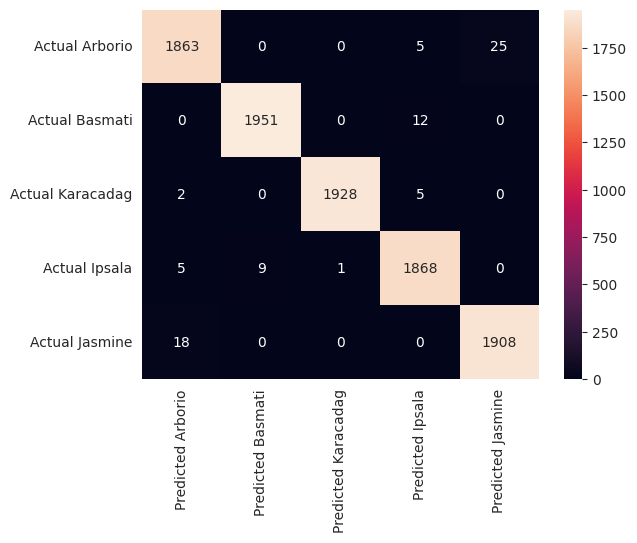

In [24]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
# Convert predictions to class labels
predicted_classes = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
# Include all class labels (0, 1, 2, 3, 4)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_classes, labels=[0, 1, 2, 3, 4]),
                  index=["Actual Arborio", "Actual Basmati", "Actual Karacadag", "Actual Ipsala", "Actual Jasmine"],
                  columns=["Predicted Arborio", "Predicted Basmati", "Predicted Karacadag", "Predicted Ipsala", "Predicted Jasmine"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=predicted_classes,  # Use predicted_classes
                            target_names=['Arborio', 'Basmati', 'Karacadag', 'Ipsala', 'Jasmine'], # Include all class names
                            digits=4))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Menyimpan model dalam format SavedModel
model_1.save('rice_classification_model.keras')  # Added .keras extension

# Menyimpan model dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()
with open('rice_classification_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Menyimpan model dalam format TFJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_1, 'rice_classification_model_tfjs')

# Specify a folder in your Drive to save the models
model_save_path = '/content/drive/MyDrive/my_artifact.txt'
# Create the directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Menyimpan model dalam format SavedModel
model_1.save(os.path.join(model_save_path, 'rice_classification_model.keras'))

# Menyimpan model dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()
with open(os.path.join(model_save_path, 'rice_classification_model.tflite'), 'wb') as f:
  f.write(tflite_model)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'model_1' is not defined

#Inference


In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('rice_classification_model.keras')

In [40]:
import cv2
import numpy as np

# Replace 'path/to/your/image.jpg' with the actual path to your image
img_path = 'Rice_Image_Dataset/Arborio/Arborio (10).jpg'  # Example path, adjust as needed

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {img_path}")
else:
    img = cv2.resize(img, (150, 150))  # Resize to match input shape
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale

In [41]:
predictions = model.predict(img)
predicted_class = np.argmax(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [42]:
rice_varieties = ['Arborio', 'Basmati', 'Karacadag', 'Ipsala', 'Jasmine']
predicted_variety = rice_varieties[predicted_class]
print(f"Predicted variety: {predicted_variety}")

Predicted variety: Arborio
